# Unit Commercial Forest Production Modelling

## Silviculture Cost Model *(description)*

Annual silviculture costs for a 1 ha plantation under the following configurable scenario settings:

- Rotation $R \in \{4,5,\dots,15\}$ years  
- Thinning $\in \{\text{"yes"},\text{"no"}\}$
  - If `thinning = "no"`:
    - Silviculture runs at full (baseline) intensity in all years.
  - If `thinning = "yes"`:
    - Thinning is implemented as intensity discounts on maintenance-related costs (no thinning cost is incurred).
    - Discount timing is rotation-dependent:
      - First discount: if $R \ge 6$, a discount factor is applied starting in year 4
      - Second discount: if $R \ge 9$, a stronger discount factor is applied starting in year 7
- Quantity weighting $\lambda_q \in (min_q, max_q)$ (i.e man-days, input quantities)
- Wage / price weighting $\lambda_p \in (min_p, max_p)$ (i.e wages and unit prices)
- Labour mix $\in \{\text{unskilled}, \text{skilled}\}$
    - If `skilled`, unskilled man-days are converted to skilled man-days using a fixed efficiency factor

Annual costs are computed for each year $t = 1,\dots,R$. 
- Labour cost and allowance, computed as $\text{Labour cost} = \lceil \text{man-days} \rceil \cdot \text{wage} + \lceil \text{man-days} \rceil \cdot \text{allowance}$
- Consumable and operational inputs computed as $\text{quantity} \cdot \text{unit price}$
- Fixed or variable silviculture items (tools, PPE, transport, overheads) as defined in the operation library

---

*Visual outputs*:
- Annual stacked cost waterfall (by operation and sub-item)
- Rotation cashflow (annual cost outflows)

## Silviculture Cost Model

In [13]:
# ================================================================
# LIBRARIES AND HELPERS
# ================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

def convex(min_val, max_val, w):
    """Convex combination: w=0 -> min, w=1 -> max."""
    w = float(np.clip(w, 0.0, 1.0))
    return (1 - w) * min_val + w * max_val

def ceil_half(x):
    """Round up to nearest 0.5 (half-day ceiling)."""
    return math.ceil(x * 2) / 2.0

def make_cost_code(year, section, sub_item):
    s = f"{year}|{section}|{sub_item}"
    return f"C_{abs(hash(s)) % 10**10:010d}"

In [14]:
# ================================================================
# LABOUR CATEGORIES (daily wage library)
# ================================================================
labour_categories = pd.DataFrame([
    {"labour_code": "L_UNSKILLED",    "desc": "Casual field worker",
     "wage_min": 5_000,  "wage_max": 12_000},
    {"labour_code": "L_SKILLED", "desc": "Experienced field worker",
     "wage_min": 10_000,  "wage_max": 20_000},
    {"labour_code": "L_OPERATOR",     "desc": "Equipment operator",
     "wage_min": 10_000,  "wage_max": 30_000},
    {"labour_code": "L_SUPERVISOR",   "desc": "Field supervisor / foreman",
     "wage_min": 15_000, "wage_max": 60_000},
    {"labour_code": "L_SURVEYOR",     "desc": "Professional surveyor / forester",
     "wage_min": 30_000, "wage_max": 90_000},
])

# ================================================================
# NON-LABOUR INPUTS (price library)
# ================================================================
non_labour_items = pd.DataFrame([
    {"item_code": "N_SEEDLING",         "desc": "Seedling delivered", "unit": "seedling",
     "price_min": 300,    "price_max": 800},
    {"item_code": "N_HERBICIDE_L",      "desc": "Herbicide concentrate","unit": "litre",
     "price_min": 15_000, "price_max": 30_000},
    {"item_code": "N_FERTILISER_KG",    "desc": "Fertiliser (NPK)",    "unit": "kg",
     "price_min": 3_000,  "price_max": 5_000},
    {"item_code": "N_DIESEL_L",         "desc": "Diesel fuel",         "unit": "litre",
     "price_min": 4_300,  "price_max": 5_500},
    {"item_code": "N_PEG",              "desc": "Boundary peg",        "unit": "peg",
     "price_min": 50,       "price_max": 150},
    {"item_code": "N_MARKING_PAINT_L",  "desc": "Marking paint",       "unit": "litre",
     "price_min": 15_000,       "price_max": 40_000},
    {"item_code": "N_HAND_TOOL_KIT",    "desc": "Hand tool kit",       "unit": "kit",
     "price_min": 50_000,       "price_max": 100_000},
    {"item_code": "N_PPE_SET",          "desc": "PPE set",             "unit": "set",
     "price_min": 50_000,       "price_max": 100_000},
    {"item_code": "N_TRUCK_TRIP_LOCAL", "desc": "Truck trip (local)",  "unit": "trip",
     "price_min": 60_000,  "price_max": 120_000},
    {"item_code": "N_PICKUP_TRIP_LOCAL","desc": "Pickup trip",         "unit": "trip",
     "price_min": 40_000,  "price_max": 80_000},
    {"item_code": "N_MECH_RIP_HA",      "desc": "Mechanical ripping",  "unit": "ha",
     "price_min": 200_000, "price_max": 330_000},
    {"item_code": "N_WATER_M3",         "desc": "Water delivered",     "unit": "m3",
     "price_min": 10_000,       "price_max": 25_000},
    {"item_code": "N_CREW_DAYALLOW",    "desc": "Meals + room per worker-day",
     "unit": "worker_day",
     "price_min": 8_000,  "price_max": 20_000},
])

# ================================================================
# OPERATIONAL INPUTS  (quantity library)
# ================================================================
def build_operation_recipes(rotation_year):
    """
    Build operation recipes up to rotation_year.
    Year 1: establishment.
    Years 2-R: generic maintenance pattern (full intensity).
    """
    if not (4 <= rotation_year <= 15):
        raise ValueError("rotation_year must be between 4 and 15.")

    ops = []

    # ---------- YEAR 1 ----------
    year1_ops = [
        # 1) Site access & boundary
        {
            "year": 1,
            "section": "Site access & boundary",
            "sub_item": "Boundary survey & marking",
            "labour_mandays": {
                "L_SURVEYOR": (0.0, 1.0),
                "L_UNSKILLED": (0.0, 2.0),
            },
            "non_labour_items": {
                "N_PEG": (0, 60),
                "N_MARKING_PAINT_L": (0.0, 0.5),
                "N_PICKUP_TRIP_LOCAL": (0.0, 1.0),
            },
        },
        {
            "year": 1,
            "section": "Site access & boundary",
            "sub_item": "Access path opening",
            "labour_mandays": {
                "L_UNSKILLED": (0.0, 5.0),
                "L_SUPERVISOR": (0.0, 2.0),
            },
            "non_labour_items": {
                "N_TRUCK_TRIP_LOCAL": (0.0, 1.0),
            },
        },
        {
            "year": 1,
            "section": "Site access & boundary",
            "sub_item": "Firebreak establishment",
            "labour_mandays": {
                "L_UNSKILLED": (0.0, 5.0),
                "L_SUPERVISOR": (0.0, 2.0),
            },
            "non_labour_items": {
                "N_PICKUP_TRIP_LOCAL": (0.0, 1.0),
                "N_DIESEL_L": (0, 7),
            },
        },

        # 2) Land preparation
        {
            "year": 1,
            "section": "Land preparation",
            "sub_item": "Initial slashing / bush clearing",
            "labour_mandays": {
                "L_UNSKILLED": (2.0, 5.0),
                "L_SUPERVISOR": (0.0, 2.0),
            },
            "non_labour_items": {
                "N_PICKUP_TRIP_LOCAL": (0.0, 1.0),
                "N_DIESEL_L": (0, 8),
            },
        },
        {
            "year": 1,
            "section": "Land preparation",
            "sub_item": "Stumping / root removal",
            "labour_mandays": {
                "L_UNSKILLED": (0.0, 5.0),
                "L_SUPERVISOR": (0.0, 2.0),
            },
            "non_labour_items": {
                "N_TRUCK_TRIP_LOCAL": (0.0, 1.0),
            },
        },
        {
            "year": 1,
            "section": "Land preparation",
            "sub_item": "Pre-plant herbicide",
            "labour_mandays": {
                "L_UNSKILLED": (0.0, 1.0),
                "L_SUPERVISOR": (0.0, 0.25),
            },
            "non_labour_items": {
                "N_HERBICIDE_L": (0.0, 1.5),
                "N_PICKUP_TRIP_LOCAL": (0.0, 0.5),
            },
        },
        {
            "year": 1,
            "section": "Land preparation",
            "sub_item": "Mechanical ripping / ploughing",
            "labour_mandays": {
                "L_UNSKILLED": (0.0, 1.0),
            },
            "non_labour_items": {
                "N_MECH_RIP_HA": (0.0, 1.0),
            },
        },

        # 3) Planting material
        {
            "year": 1,
            "section": "Planting material",
            "sub_item": "Seedlings (delivered)",
            "labour_mandays": {},
            "non_labour_items": {
                "N_SEEDLING": (1000, 1300),
            },
        },
        {
            "year": 1,
            "section": "Planting material",
            "sub_item": "Seedling handling & on-site transport",
            "labour_mandays": {
                "L_UNSKILLED": (0.5, 2.0),
            },
            "non_labour_items": {
                "N_PICKUP_TRIP_LOCAL": (0.25, 0.75),
            },
        },

        # 4) Layout & soil work
        {
            "year": 1,
            "section": "Layout & soil work",
            "sub_item": "Lining & pegging",
            "labour_mandays": {
                "L_UNSKILLED": (1.0, 2.5),
                "L_SUPERVISOR": (0.0, 0.5),
            },
            "non_labour_items": {
                "N_PEG": (0, 260),
            },
        },
        {
            "year": 1,
            "section": "Layout & soil work",
            "sub_item": "Pitting (planting holes)",
            "labour_mandays": {
                "L_UNSKILLED": (2.0, 5.0),
                "L_SUPERVISOR": (0.0, 0.5),
            },
            "non_labour_items": {
                "N_TRUCK_TRIP_LOCAL": (0.25, 0.75),
            },
        },
        {
            "year": 1,
            "section": "Layout & soil work",
            "sub_item": "Fertiliser / soil amendment",
            "labour_mandays": {
                "L_UNSKILLED": (0.0, 1.0),
            },
            "non_labour_items": {
                "N_FERTILISER_KG": (0, 80),
            },
        },

        # 5) Planting operations
        {
            "year": 1,
            "section": "Planting operations",
            "sub_item": "Planting",
            "labour_mandays": {
                "L_UNSKILLED": (2.0, 4.0),
                "L_SUPERVISOR": (0.25, 1.0),
            },
            "non_labour_items": {
                "N_TRUCK_TRIP_LOCAL": (0.2, 0.8),
                "N_WATER_M3": (0.0, 1.0),
            },
        },
        {
            "year": 1,
            "section": "Planting operations",
            "sub_item": "Initial watering",
            "labour_mandays": {
                "L_UNSKILLED": (0.0, 2.0),
            },
            "non_labour_items": {
                "N_WATER_M3": (0.0, 2.0),
            },
        },
        {
            "year": 1,
            "section": "Planting operations",
            "sub_item": "Beating-up",
            "labour_mandays": {
                "L_UNSKILLED": (0.0, 2.0),
            },
            "non_labour_items": {
                "N_SEEDLING": (0, int(0.2 * 1111)),
            },
        },

        # 6) Silviculture (Y1)
        {
            "year": 1,
            "section": "Silviculture (Y1)",
            "sub_item": "Herbicide for post-plant spot spraying",
            "labour_mandays": {
                "L_UNSKILLED": (0.0, 1.5),
                "L_SUPERVISOR": (0.0, 0.25),
            },
            "non_labour_items": {
                "N_HERBICIDE_L": (0.0, 1.5),
                "N_PICKUP_TRIP_LOCAL": (0.0, 0.5),
            },
        },
        {
            "year": 1,
            "section": "Silviculture (Y1)",
            "sub_item": "Fuel & oil for brush cutters",
            "labour_mandays": {
                "L_OPERATOR": (0.0, 1.0),
            },
            "non_labour_items": {
                "N_DIESEL_L": (0, 15),
            },
        },
        {
            "year": 1,
            "section": "Silviculture (Y1)",
            "sub_item": "Pruning saws & blades",
            "labour_mandays": {},
            "non_labour_items": {
                "N_HAND_TOOL_KIT": (0.0, 0.5),
            },
        },

        # 7) Tools, PPE and others
        {
            "year": 1,
            "section": "Tools, PPE and others",
            "sub_item": "PPE initial kit",
            "labour_mandays": {},
            "non_labour_items": {
                "N_PPE_SET": (0.0, 4.0),
            },
        },
        {
            "year": 1,
            "section": "Tools, PPE and others",
            "sub_item": "Hand tools initial purchase",
            "labour_mandays": {},
            "non_labour_items": {
                "N_HAND_TOOL_KIT": (0.0, 1.5),
            },
        },
        {
            "year": 1,
            "section": "Tools, PPE and others",
            "sub_item": "Tool repair & replacement (Y1)",
            "labour_mandays": {},
            "non_labour_items": {
                "N_HAND_TOOL_KIT": (0.0, 0.4),
            },
        },
        {
            "year": 1,
            "section": "Tools, PPE and others",
            "sub_item": "Contingency/Safety & compliance",
            "labour_mandays": {},
            "non_labour_items": {},
        },
        {
            "year": 1,
            "section": "Tools, PPE and others",
            "sub_item": "Overhead",
            "labour_mandays": {},
            "non_labour_items": {},
        },
    ]
    ops.extend(year1_ops)

    # ---------- Years 2..R: generic maintenance pattern (full intensity) ----------
    for y in range(2, rotation_year + 1):
        ops += [
            {
                "year": y,
                "section": f"Silviculture (Y{y})",
                "sub_item": "Herbicide & chemicals",
                "labour_mandays": {
                    "L_UNSKILLED": (0.0, 1.3),
                    "L_SUPERVISOR": (0.0, 0.2),
                },
                "non_labour_items": {
                    "N_HERBICIDE_L": (0.0, 1.3),
                    "N_TRUCK_TRIP_LOCAL": (0.0, 0.4),
                },
            },
            {
                "year": y,
                "section": f"Silviculture (Y{y})",
                "sub_item": "Fuel & oil for equipment",
                "labour_mandays": {
                    "L_OPERATOR": (0.0, 0.9),
                },
                "non_labour_items": {
                    "N_DIESEL_L": (0, 12),
                },
            },
            {
                "year": y,
                "section": f"Silviculture (Y{y})",
                "sub_item": "Pruning saws & blades",
                "labour_mandays": {},
                "non_labour_items": {
                    "N_HAND_TOOL_KIT": (0.0, 0.2),
                },
            },
            {
                "year": y,
                "section": "Labour welfare & ops",
                "sub_item": f"Labour transport (Y{y})",
                "labour_mandays": {},
                "non_labour_items": {
                    "N_TRUCK_TRIP_LOCAL": (0.0, 0.9),
                },
            },
            {
                "year": y,
                "section": "Tools, PPE and others",
                "sub_item": f"Tools & PPE replacement (Y{y})",
                "labour_mandays": {},
                "non_labour_items": {
                    "N_HAND_TOOL_KIT": (0.0, 0.2),
                    "N_PPE_SET": (0.0, 0.4),
                },
            },
            {
                "year": y,
                "section": "Tools, PPE and others",
                "sub_item": f"Contingency/Safety & compliance (Y{y})",
                "labour_mandays": {},
                "non_labour_items": {},
            },
            {
                "year": y,
                "section": "Tools, PPE and others",
                "sub_item": f"Overhead (Y{y})",
                "labour_mandays": {},
                "non_labour_items": {},
            },
        ]
    return ops


In [15]:
# ================================================================
# THINNING DISCOUNT
# ================================================================
def thinning_discount_factor(year, rotation_year, thinning="no",
                            d1=0.85, d2=0.75,
                            start1_year=4, start2_year=7,
                            trigger1_R=6, trigger2_R=9):
    """
    If thinning="yes", apply discounts on MAINTENANCE years based on rotation:
      - If R >= trigger1_R: apply factor d1 from year >= start1_year
      - If R >= trigger2_R: apply factor d2 from year >= start2_year (overrides d1)
    Otherwise factor = 1.0
    """
    if thinning != "yes":
        return 1.0

    if rotation_year >= trigger2_R and year >= start2_year:
        return float(d2)

    if rotation_year >= trigger1_R and year >= start1_year:
        return float(d1)

    return 1.0

def is_maintenance_row(year, section):
    """
    Where thinning discounts act - keep Year 1 intact; 
    discount maintenance years (>=2) for silviculture/ops overhead.
    """
    if year <= 1:
        return False
    if section.startswith("Silviculture"):
        return True
    if section in {"Labour welfare & ops", "Tools, PPE and others"}:
        return True
    return False

In [16]:
# ================================================================
# COST ENGINE
# ================================================================
def _index_libs(labour_categories, non_labour_items):
    L = labour_categories.set_index("labour_code")[["wage_min", "wage_max", "desc"]].copy()
    N = non_labour_items.set_index("item_code")[["price_min", "price_max", "desc", "unit"]].copy()
    return L, N

def compute_costs(
    rotation_year,
    thinning="no",
    qty_weight=0.5,          # affects man-days and input quantities (convex min/max)
    wage_weight=0.5,         # affects wages & input prices (convex min/max)
    labour_mix="unskilled",  # {"unskilled","skilled"}: converts L_UNSKILLED -> L_SKILLED @ skilled_factor
    skilled_factor=0.65,     # skilled man-days = skilled_factor * unskilled man-days
    d1=0.85, d2=0.75,        # thinning discount factors
):
    """
    Returns:
      cost_df: rows at (year, section, sub_item) with total cost, plus diagnostics.
    Labour cost/allowance rule:
      labour_cost = ceil(md)*wage + ceil_half(md)*allowance
      (allowance applied to ALL labour categories)
    """
    if labour_mix not in {"unskilled", "skilled"}:
        raise ValueError("labour_mix must be one of {'unskilled','skilled'}")
    if thinning not in {"yes", "no"}:
        raise ValueError("thinning must be one of {'yes','no'}")

    L, N = _index_libs(labour_categories, non_labour_items)

    # allowance price (weighted)
    allow_price = convex(N.loc["N_CREW_DAYALLOW", "price_min"], N.loc["N_CREW_DAYALLOW", "price_max"], wage_weight)

    ops = build_operation_recipes(rotation_year)

    rows = []
    for op in ops:
        y = int(op["year"])
        section = op["section"]
        sub_item = op["sub_item"]

        # ---------- quantities ----------
        labour_mandays = {}
        for lc, (mn, mx) in op.get("labour_mandays", {}).items():
            md = convex(mn, mx, qty_weight)
            if md <= 0:
                continue
            labour_mandays[lc] = md

        nonlab_qty = {}
        for ic, (mn, mx) in op.get("non_labour_items", {}).items():
            q = convex(mn, mx, qty_weight)
            if q <= 0:
                continue
            nonlab_qty[ic] = q

        # ---------- labour mix transform (only for basic work coded as L_UNSKILLED) ----------
        if labour_mix == "skilled" and "L_UNSKILLED" in labour_mandays:
            md_u = labour_mandays.pop("L_UNSKILLED")
            labour_mandays["L_SKILLED"] = labour_mandays.get("L_SKILLED", 0.0) + skilled_factor * md_u

        # ---------- labour cost ----------
        labour_cost = 0.0
        labour_md_total = 0.0
        for lc, md in labour_mandays.items():
            if lc not in L.index:
                raise KeyError(f"Unknown labour_code {lc}")
            wage = convex(L.loc[lc, "wage_min"], L.loc[lc, "wage_max"], wage_weight)

            labour_md_total += md
            labour_cost += math.ceil(md) * wage + ceil_half(md) * allow_price

        # ---------- non-labour cost ----------
        nonlab_cost = 0.0
        for ic, q in nonlab_qty.items():
            if ic not in N.index:
                raise KeyError(f"Unknown item_code {ic}")
            price = convex(N.loc[ic, "price_min"], N.loc[ic, "price_max"], wage_weight)
            nonlab_cost += q * price

        base_cost = labour_cost + nonlab_cost

        # ---------- thinning discount (maintenance intensity) ----------
        disc = 1.0
        if is_maintenance_row(y, section):
            disc = thinning_discount_factor(
                year=y, rotation_year=rotation_year, thinning=thinning,
                d1=d1, d2=d2
            )

        total_cost = base_cost * disc

        rows.append({
            "year": y,
            "section": section,
            "sub_item": sub_item,
            "cost": total_cost,
            "base_cost": base_cost,
            "discount_factor": disc,
            "labour_cost": labour_cost * disc,
            "non_labour_cost": nonlab_cost * disc,
            "labour_mandays_total": labour_md_total,
            "allowance_price": allow_price,
            "cost_code": make_cost_code(y, section, sub_item),
        })

    cost_df = pd.DataFrame(rows).sort_values(["year", "section", "sub_item"]).reset_index(drop=True)
    return cost_df



In [17]:
# ================================================================
# Waterfall plotting (per year)
# ================================================================
section_colors = {
    "Site access & boundary": "#4C72B0",
    "Land preparation":        "#55A868",
    "Planting material":       "#C1A72F",
    "Layout & soil work":      "#64B5A7",
    "Planting operations":     "#4CADA7",
    "Silviculture (Y1)":       "#E18727",
    "Labour welfare & ops":    "#B076B0",
    "Tools, PPE and others":   "#8DA0CB",
}

def get_section_color(section):
    if section.startswith("Silviculture"):
        return section_colors["Silviculture (Y1)"]
    return section_colors.get(section, "#999999")


def plot_stacked_waterfall(cost_df, year=1, figsize=(14, 5)):
    """
    Stacked waterfall for a given year with a legend listing all sub-costs.
    Assumes cost_df already has 'cost_code'.
    """
    df = cost_df[cost_df["year"] == year].copy()
    if df.empty:
        raise ValueError(f"No cost rows for year={year}.")

    section_order = [
        "Site access & boundary",
        "Land preparation",
        "Planting material",
        "Layout & soil work",
        "Planting operations",
        f"Silviculture (Y{year})" if f"Silviculture (Y{year})" in df.section.values
            else "Silviculture (Y1)",
        "Labour welfare & ops",
        "Tools, PPE and others",
    ]
    section_order = [s for s in section_order if s in df.section.unique()]

    df["section"] = pd.Categorical(df["section"],
                                   categories=section_order,
                                   ordered=True)
    df.sort_values(["section", "sub_item"], inplace=True)

    fig, ax = plt.subplots(figsize=figsize)

    x_positions = np.arange(len(section_order))
    cumulative = 0.0

    legend_entries = []  # (label, color, alpha)

    for i, section in enumerate(section_order):
        sub = df[df["section"] == section]
        base = cumulative
        total = sub["cost"].sum()
        base_color = get_section_color(section)

        alphas = np.linspace(0.4, 1.0, len(sub)) if len(sub) > 0 else []

        for alpha, (_, row) in zip(alphas, sub.iterrows()):
            ax.bar(
                x_positions[i],
                row["cost"],
                bottom=base,
                alpha=alpha,
                color=base_color,
                edgecolor="black",
                linewidth=0.3,
            )
            base += row["cost"]

            label = f"{row['sub_item']}  ({row['cost']:,.0f} UGX)"
            legend_entries.append((label, base_color, alpha))

        ax.hlines(
            cumulative + total,
            x_positions[i] - 0.4,
            x_positions[i] + 0.4,
            linestyles="dotted",
            color="grey",
            linewidth=0.8,
        )
        cumulative += total

    ax.axhline(cumulative, linestyle="--", color="black", linewidth=0.8)
    if len(x_positions) > 0:
        ax.text(
            x_positions[-1] + 0.4,
            cumulative,
            f"Total: {cumulative:,.0f} UGX",
            va="bottom",
            ha="left",
            fontsize=9,
        )

    ax.set_xticks(x_positions)
    ax.set_xticklabels(section_order, rotation=35, ha="right")
    ax.set_ylabel("Cost per ha (UGX)")
    ax.set_title(f"Year {year} Cost Waterfall")

    # -------- LEGEND --------
    handles = [
        plt.Line2D(
            [0], [0],
            color=color,
            alpha=alpha,
            marker="s",
            markersize=6,
            linestyle=""
        )
        for (_, color, alpha) in legend_entries
    ]
    labels = [label for (label, _, _) in legend_entries]

    if handles:
        fig.legend(
            handles,
            labels,
            title="Sub-cost legend",
            loc="lower center",
            ncol=3,
            fontsize=7,
            title_fontsize=8,
            frameon=True,
            bbox_to_anchor=(0.5, -0.33)  # more space below
        )

    # Reserve bottom margin for the legend (DO NOT call tight_layout twice)
    fig.tight_layout(rect=[0, 0.18, 1, 1])
    return fig, ax


# ================================================================
# Cashflow bar plot + cumulative line
# ================================================================
def plot_cashflow(cost_df, rotation_year, figsize=(10, 4)):
    yearly_cost = (
        cost_df.groupby("year")["cost"]
        .sum()
        .reindex(range(1, rotation_year + 1), fill_value=0)
    )

    years = yearly_cost.index.values
    cashflow = -yearly_cost.values          # negative (cost outflow)
    cumulative = cashflow.cumsum()

    fig, ax1 = plt.subplots(figsize=figsize)

    ax1.bar(years, cashflow, width=0.6)
    ax1.axhline(0, color="black", linewidth=0.8)
    ax1.set_xlabel("Year")
    ax1.set_ylabel("Net cashflow per ha (UGX)")

    ax2 = ax1.twinx()
    ax2.plot(years, cumulative, marker="o", linewidth=1.5)
    ax2.set_ylabel("Cumulative cashflow per ha (UGX)")

    ax1.set_title("Rotation cashflow: yearly (bars) + cumulative (line)")
    fig.tight_layout()
    return fig, ax1, ax2



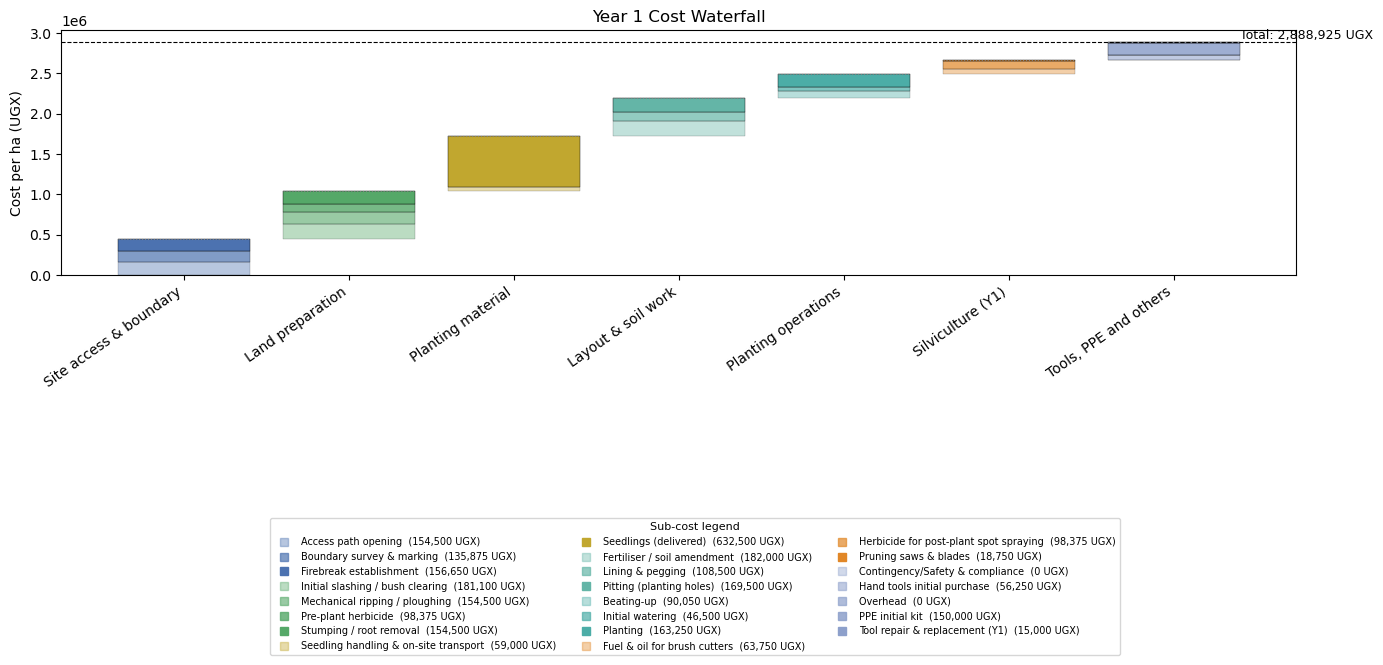

In [23]:
# ================================================================
# EXAMPLE RUN
# ================================================================
if __name__ == "__main__":
    R = 8
    cost_df = compute_costs(
        rotation_year=R,
        thinning="yes",        # "yes" or "no"
        qty_weight=0.5,        # 0=min quantities, 1=max quantities
        wage_weight=0.5,       # 0=min wages/prices, 1=max wages/prices
        labour_mix="skilled",  # "unskilled" or "skilled"
        skilled_factor=0.65,   # skilled MD = 0.65 * unskilled MD
        d1=0.85, d2=0.75       # thinning discount factors
    )

    # Waterfalls
    plot_stacked_waterfall(cost_df, year=1)
    plt.show()

    # Optional: Cashflow over rotation
    # plot_cashflow(cost_df, rotation_year=R)
    # plt.show()

    # Optional: inspect yearly totals
    # print(cost_df.groupby("year")["cost"].sum().round(0))


## Forest Production Cashflow Model *(description)*

Cashflow for a 1 ha plantation, conditional on the silviculture costs model and the following scenario settings:
- Initial stocking $N_0$ (trees per hectare)
- Thinning schedule and prices: Each thinning year $t \in \mathcal{T}$ has an associated price per tree $p_t^{\text{thin}}$ and removes a fixed fraction $\theta_t \in (0,1)$ of the standing trees
- Final harvest: Occurs in year $R$. All remaining trees are harvested at a roundwood price per tree $p^{\text{final}}$
- Thinning revenue: $\text{Revenue}_t^{\text{thin}}=\theta_t \cdot N_t \cdot p_t^{\text{thin}}$ for $t \in \mathcal{T}$. 
- Final harvest revenue: $\text{Revenue}_R^{\text{final}} = N_R \cdot p^{\text{final}}$ at $t = R$
For each year $t = 1,\dots,R$:
- $CF_t = \text{Revenue}_t - \text{Silviculture cost}_t$
- Net Present Value (NPV): $\text{NPV} = \sum_{t=1}^{R}\frac{CF_t}{(1+r)^t}$
- Internal Rate of Return (IRR): $\sum_{t=1}^{R}\frac{CF_t}{(1+\text{IRR})^t}=0$
- Payback period: The first year $t$ for which cumulative cashflow becomes non-negative


## Forest Production Cashflow Model

In [26]:
# ================================================================
# ECONOMIC INPUT SCENARIOS
# ================================================================
economic_scenario = {
    # Stand structure
    "initial_trees_per_ha": 1111,

    # Thinning schedule (year → % trees removed)
    # Percentages are fractions of standing trees at that time
    "thinnings": {
        4: 0.30,   # first thinning: remove 30%
        7: 0.30,   # second thinning: remove 30% of remaining
    },

    # Prices per tree (UGX)
    "price_thinning_tree": {
        4: 5_000,   # per tree removed in Y4
        7: 8_000,   # per tree removed in Y7
    },

    # Final harvest
    "final_harvest_year": 8,
    "price_final_tree": 35_000,  # roundwood price per tree

    # Discount rate for NPV
    "discount_rate": 0.15,
}


In [28]:
# ================================================================
# REVENUE ENGINE
# ================================================================
def compute_revenues(rotation_year, econ):
    """
    Returns DataFrame with yearly revenues based on thinning + final harvest.
    """
    trees = econ["initial_trees_per_ha"]
    rows = []

    for year in range(1, rotation_year + 1):
        revenue = 0.0

        # Thinning revenue
        if year in econ.get("thinnings", {}):
            frac = econ["thinnings"][year]
            trees_removed = trees * frac
            price = econ["price_thinning_tree"][year]
            revenue = trees_removed * price
            trees -= trees_removed

        # Final harvest
        if year == econ["final_harvest_year"]:
            revenue += trees * econ["price_final_tree"]
            trees = 0

        rows.append({
            "year": year,
            "revenue": revenue
        })

    return pd.DataFrame(rows)


In [30]:
# ================================================================
# CASHFLOW CONSTRUCTION
# ================================================================
def build_cashflow(cost_df, revenue_df, rotation_year):
    """
    Returns DataFrame with cost, revenue, net cashflow, cumulative cashflow.
    """
    yearly_cost = (
        cost_df.groupby("year")["cost"]
        .sum()
        .reindex(range(1, rotation_year + 1), fill_value=0.0)
    )

    yearly_rev = (
        revenue_df.set_index("year")["revenue"]
        .reindex(range(1, rotation_year + 1), fill_value=0.0)
    )

    df = pd.DataFrame({
        "year": yearly_cost.index,
        "cost": yearly_cost.values,
        "revenue": yearly_rev.values,
    })

    df["net_cashflow"] = df["revenue"] - df["cost"]
    df["cumulative_cashflow"] = df["net_cashflow"].cumsum()

    return df


In [32]:
# ================================================================
# INVESTMENT METRICS
# ================================================================
def investment_metrics(cashflow_df, discount_rate):
    """
    Returns dict with NPV, IRR, payback year.
    """
    cf = cashflow_df["net_cashflow"].values
    years = cashflow_df["year"].values

    # NPV
    npv = np.sum(cf / (1 + discount_rate) ** years)

    # IRR
    try:
        irr = np.irr(cf)
    except Exception:
        irr = np.nan

    # Payback period
    cum = cashflow_df["cumulative_cashflow"].values
    payback = next((years[i] for i in range(len(cum)) if cum[i] >= 0), None)

    return {
        "NPV": npv,
        "IRR": irr,
        "Payback_year": payback,
        "Total_cost": cashflow_df["cost"].sum(),
        "Total_revenue": cashflow_df["revenue"].sum(),
    }


In [34]:
# ================================================================
# CASHFLOW VISUAL
# ================================================================
def plot_cashflow_economic(cashflow_df, figsize=(10, 4)):
    years = cashflow_df["year"].values
    cf = cashflow_df["net_cashflow"].values
    cum = cashflow_df["cumulative_cashflow"].values

    colors = ["#C44E52" if v < 0 else "#55A868" for v in cf]

    fig, ax1 = plt.subplots(figsize=figsize)

    ax1.bar(years, cf, color=colors, width=0.6)
    ax1.axhline(0, color="black", linewidth=0.8)
    ax1.set_xlabel("Year")
    ax1.set_ylabel("Net cashflow per ha (UGX)")

    ax2 = ax1.twinx()
    ax2.plot(years, cum, marker="o", linewidth=1.5)
    ax2.set_ylabel("Cumulative cashflow per ha (UGX)")

    ax1.set_title("Economic cashflow (thinning + final harvest)")
    fig.tight_layout()
    return fig, ax1, ax2


C:\Users\JasonOyugi\AppData\Local\Temp\ipykernel_11496\3692271356.py:16: DeprecationWarning: In accordance with NEP 32, the function irr was removed from NumPy version 1.20.  A replacement for this function is available in the numpy_financial library: https://pypi.org/project/numpy-financial
  irr = np.irr(cf)


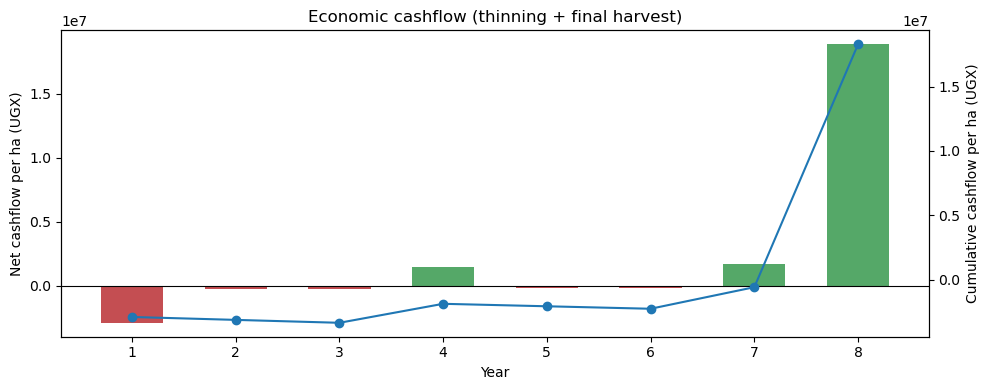

NPV: 4,628,092.81
IRR: nan
Payback_year: 8
Total_cost: 4,301,581.25
Total_revenue: 22,586,630.00


In [36]:
# ================================================================
# EXAMPLE RUN
# ================================================================
R = 8

# 1. Costs (already built earlier)
cost_df = compute_costs(
    rotation_year=R,
    thinning="yes",
    qty_weight=0.5,
    wage_weight=0.5,
    labour_mix="skilled",
)

# 2. Revenues
revenue_df = compute_revenues(R, economic_scenario)

# 3. Cashflow
cashflow_df = build_cashflow(cost_df, revenue_df, R)

# 4. Metrics
metrics = investment_metrics(
    cashflow_df,
    discount_rate=economic_scenario["discount_rate"]
)

# 5. Plot
plot_cashflow_economic(cashflow_df)
plt.show()

# 6. Print metrics
for k, v in metrics.items():
    print(f"{k}: {v:,.2f}" if isinstance(v, (int, float)) else f"{k}: {v}")
